     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymrmr: filename=pymrmr-0.1.11-cp311-cp311-linux_x86_64.whl size=401294 sha256=9551d15ef90e6bb7f0c958b5df76d480d44e51e4a979342e9af53cbe072f57a3
  Stored in directory: /root/.cache/pip/wheels/a0/d7/97/71bca023a0dbdceab24a556649d661e71114f4eaaf4dda56d6
Successfully built pymrmr
==== SHAP Importance Summary (Top 14 Features) ====
                     Mean SHAP  Std SHAP  Rank
A6                    0.107925  0.002851   1.0
A9                    0.102939  0.002707   2.0
A7                    0.100970  0.003072   3.0
A5                    0.072014  0.001981   4.0
A2                    0.069374  0.002188   5.0
A4                    0.064759  0.001796   6.0
A8                    0.049895  0.001909   7.0
A3                    0.040457  0.001726   8.0
A10                   0.028006  0.001031   9.0
Ethnicity             0.015544  0.001029  10.0
Age_Mons     

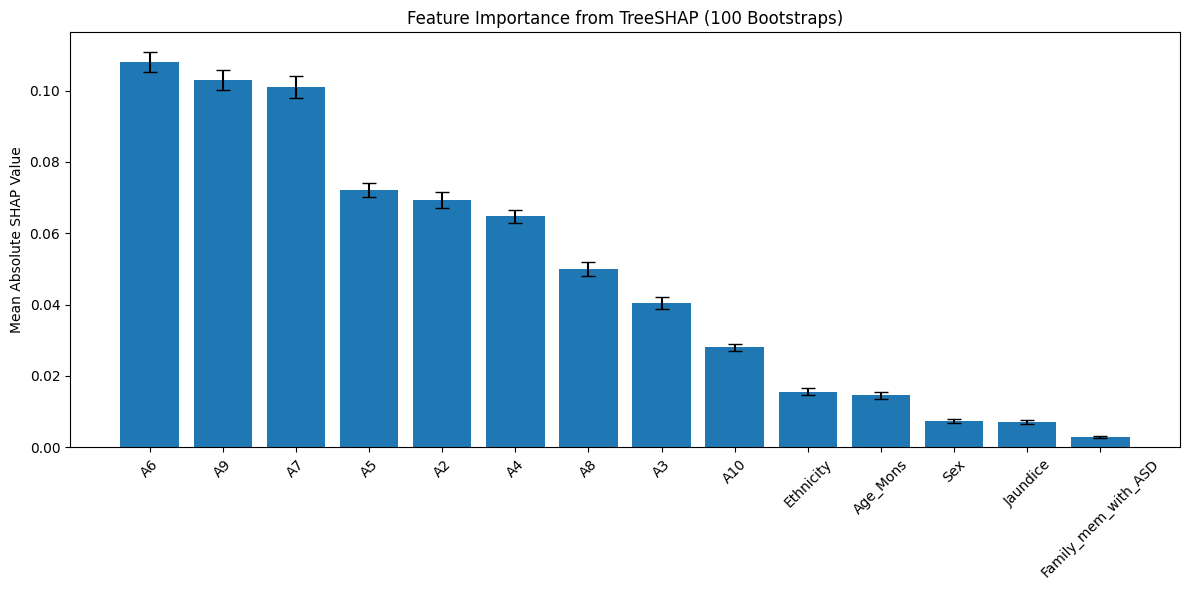


==== Top-5 Feature Comparison ====
Top-5 TreeSHAP Features: ['A6', 'A9', 'A7', 'A5', 'A2']
Top-5 mRMR Features    : ['A2', 'A6', 'Sex', 'A7', 'A3']
Overlap                : {'A7', 'A6', 'A2'}
Jaccard Similarity     : 0.43


In [1]:
# Install required packages
!pip install shap
!pip install pymrmr

# Import required libraries
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from pymrmr import mRMR

# Load the dataset
df = pd.read_csv("Autism-toddler.csv")

# Create feature set and target set
X = df.drop(['Class/ASD Traits ', 'Who completed the test', 'Qchat-10-Score', 'Case_No'], axis=1)
y = df['Class/ASD Traits ']

# Encode categorical variables
categorical_columns = ['Sex', 'Ethnicity', 'Jaundice', 'Family_mem_with_ASD']
le = LabelEncoder()
for col in categorical_columns:
    X[col] = le.fit_transform(X[col])

# Use mRMR to select the top 14 features
k = 14
top_k_feature_names = mRMR(X, 'MID', k)
X_mrmr = X[top_k_feature_names]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_mrmr, y, test_size=0.2, random_state=2)

# Train a Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Perform TreeSHAP across multiple bootstrap trials
n_trials = 100
shap_importance_matrix = []

for seed in range(n_trials):
    # Bootstrap the test set
    X_boot = X_test.sample(frac=1.0, replace=True, random_state=seed)

    # TreeSHAP
    explainer = shap.TreeExplainer(clf)
    shap_vals = explainer.shap_values(X_boot)

    # Handle both SHAP output formats
    if isinstance(shap_vals, list):
        shap_values_class1 = shap_vals[1]  # Class 1 (ASD = Yes)
    elif isinstance(shap_vals, np.ndarray) and shap_vals.ndim == 3:
        shap_values_class1 = shap_vals[:, :, 1]
    else:
        raise ValueError("Unexpected SHAP value format")

    # Compute mean absolute SHAP values per feature for this trial
    mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)
    shap_importance_matrix.append(mean_abs_shap)

# Convert to DataFrame
shap_df = pd.DataFrame(shap_importance_matrix, columns=top_k_feature_names)

# Compute mean and std SHAP importances
shap_mean = shap_df.mean()
shap_std = shap_df.std()

# Create summary DataFrame
shap_summary = pd.DataFrame({
    'Mean SHAP': shap_mean,
    'Std SHAP': shap_std
}).sort_values(by='Mean SHAP', ascending=False)

# Add rank
shap_summary['Rank'] = shap_summary['Mean SHAP'].rank(ascending=False)

# Display summary table
print("==== SHAP Importance Summary (Top 14 Features) ====")
print(shap_summary)

# Plot SHAP importance with error bars
plt.figure(figsize=(12, 6))
plt.bar(shap_summary.index, shap_summary['Mean SHAP'], yerr=shap_summary['Std SHAP'], capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Mean Absolute SHAP Value")
plt.title("Feature Importance from TreeSHAP (100 Bootstraps)")
plt.tight_layout()
plt.show()

# Optional: Compare Top-5 SHAP vs Top-5 mRMR
top5_shap = shap_summary.head(5).index.tolist()
top5_mrmr = top_k_feature_names[:5]
intersection = set(top5_shap) & set(top5_mrmr)

print("\n==== Top-5 Feature Comparison ====")
print(f"Top-5 TreeSHAP Features: {top5_shap}")
print(f"Top-5 mRMR Features    : {top5_mrmr}")
print(f"Overlap                : {intersection}")
print(f"Jaccard Similarity     : {len(intersection) / len(set(top5_shap + top5_mrmr)):.2f}")


In [ ]:
# Adolescent

==== SHAP Importance Summary (Top 7 Features) ====
               Mean SHAP  Std SHAP  Rank
A8_Score        0.143379  0.010488   1.0
contry_of_res   0.126124  0.012341   2.0
A6_Score        0.099130  0.011181   3.0
A7_Score        0.089657  0.008137   4.0
A2_Score        0.052367  0.007816   5.0
age_desc        0.027044  0.008999   6.0
jundice         0.015839  0.003347   7.0


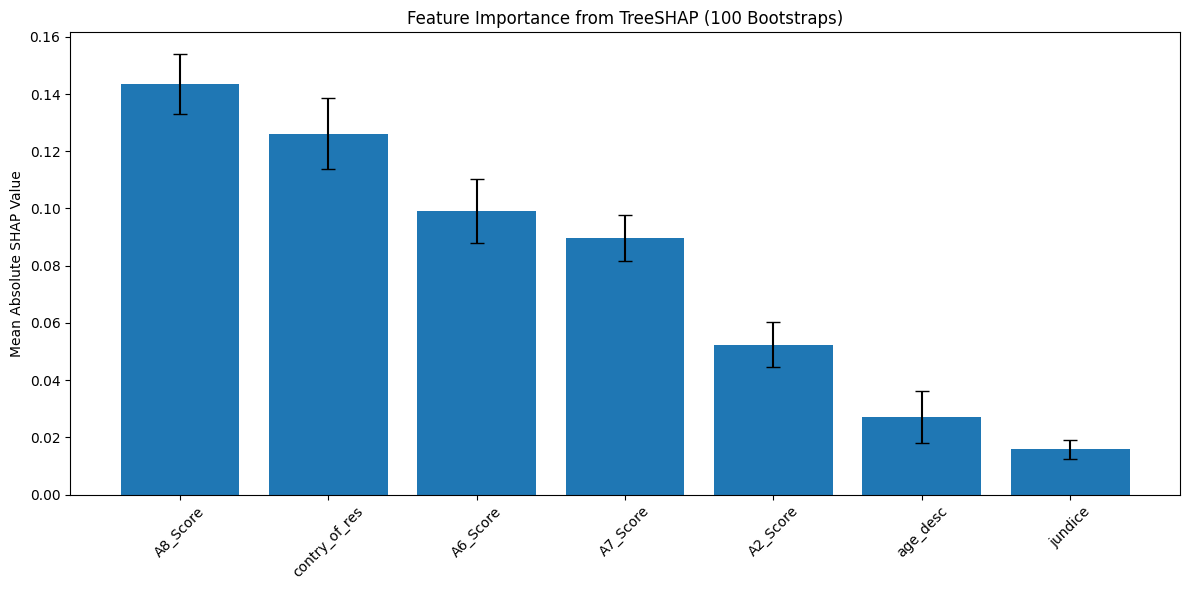


==== Top-5 Feature Comparison ====
Top-5 TreeSHAP Features: ['A8_Score', 'contry_of_res', 'A6_Score', 'A7_Score', 'A2_Score']
Top-5 mRMR Features    : ['contry_of_res', 'age_desc', 'A6_Score', 'A2_Score', 'A8_Score']
Overlap                : {'contry_of_res', 'A2_Score', 'A8_Score', 'A6_Score'}
Jaccard Similarity     : 0.67


In [3]:
# Install necessary libraries
!pip install shap
!pip install pymrmr

# Imports
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pymrmr import mRMR

# Load dataset
df = pd.read_csv("Autism-Adolescent.csv")

# Prepare feature and target sets
X = df.drop(['id', 'Class/ASD', 'austim', 'used_app_before', 'result'], axis=1)
y = df['Class/ASD']

# Encode categorical columns
categorical_columns = ['gender', 'ethnicity', 'jundice', 'contry_of_res', 'age_desc', 'relation']
le = LabelEncoder()
for col in categorical_columns:
    X[col] = le.fit_transform(X[col])

# Set feature names
feature_names = X.columns.tolist()

# Select top 7 features using mRMR
k = 7
top_k_feature_names = mRMR(X, 'MID', k)
X_mrmr = X[top_k_feature_names]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_mrmr, y, test_size=0.2, random_state=2)

# Train Random Forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# TreeSHAP analysis over multiple bootstrap trials
n_trials = 100
shap_importance_matrix = []

for seed in range(n_trials):
    # Bootstrap test set using only selected features
    X_boot = X_test.sample(frac=1.0, replace=True, random_state=seed)

    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(clf)
    shap_vals = explainer.shap_values(X_boot)

    # Handle SHAP output formats
    if isinstance(shap_vals, list):
        shap_values_class1 = shap_vals[1]  # Class 1 (ASD = Yes)
    elif isinstance(shap_vals, np.ndarray) and shap_vals.ndim == 3:
        shap_values_class1 = shap_vals[:, :, 1]
    else:
        raise ValueError("Unexpected SHAP value format")

    # Compute mean absolute SHAP values
    mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)

    # Validate SHAP shape
    if len(mean_abs_shap) == len(top_k_feature_names):
        shap_importance_matrix.append(mean_abs_shap)
    else:
        raise ValueError(f"SHAP output size {len(mean_abs_shap)} != selected features {len(top_k_feature_names)}")

# Create SHAP importance DataFrame
shap_df = pd.DataFrame(shap_importance_matrix, columns=top_k_feature_names)

# Calculate mean and std SHAP importances
shap_mean = shap_df.mean()
shap_std = shap_df.std()

# Build SHAP summary DataFrame
shap_summary = pd.DataFrame({
    'Mean SHAP': shap_mean,
    'Std SHAP': shap_std
}).sort_values(by='Mean SHAP', ascending=False)

# Add feature rank
shap_summary['Rank'] = shap_summary['Mean SHAP'].rank(ascending=False)

# Print SHAP importance summary
print("==== SHAP Importance Summary (Top 7 Features) ====")
print(shap_summary)

# Plot SHAP importance with error bars
plt.figure(figsize=(12, 6))
plt.bar(shap_summary.index, shap_summary['Mean SHAP'], yerr=shap_summary['Std SHAP'], capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Mean Absolute SHAP Value")
plt.title("Feature Importance from TreeSHAP (100 Bootstraps)")
plt.tight_layout()
plt.show()

# Compare top-5 SHAP and mRMR features
top5_shap = shap_summary.head(5).index.tolist()
top5_mrmr = top_k_feature_names[:5]
intersection = set(top5_shap) & set(top5_mrmr)

print("\n==== Top-5 Feature Comparison ====")
print(f"Top-5 TreeSHAP Features: {top5_shap}")
print(f"Top-5 mRMR Features    : {top5_mrmr}")
print(f"Overlap                : {intersection}")
print(f"Jaccard Similarity     : {len(intersection) / len(set(top5_shap + top5_mrmr)):.2f}")


In [4]:
# Adult Dataset

==== SHAP Importance Summary (Top 7 Features) ====
               Mean SHAP  Std SHAP  Rank
A5_Score        0.209487  0.006213   1.0
contry_of_res   0.101326  0.007231   2.0
A7_Score        0.100314  0.004161   3.0
A8_Score        0.068710  0.004661   4.0
austim          0.032872  0.003644   5.0
gender          0.024695  0.001923   6.0
jundice         0.012313  0.001212   7.0


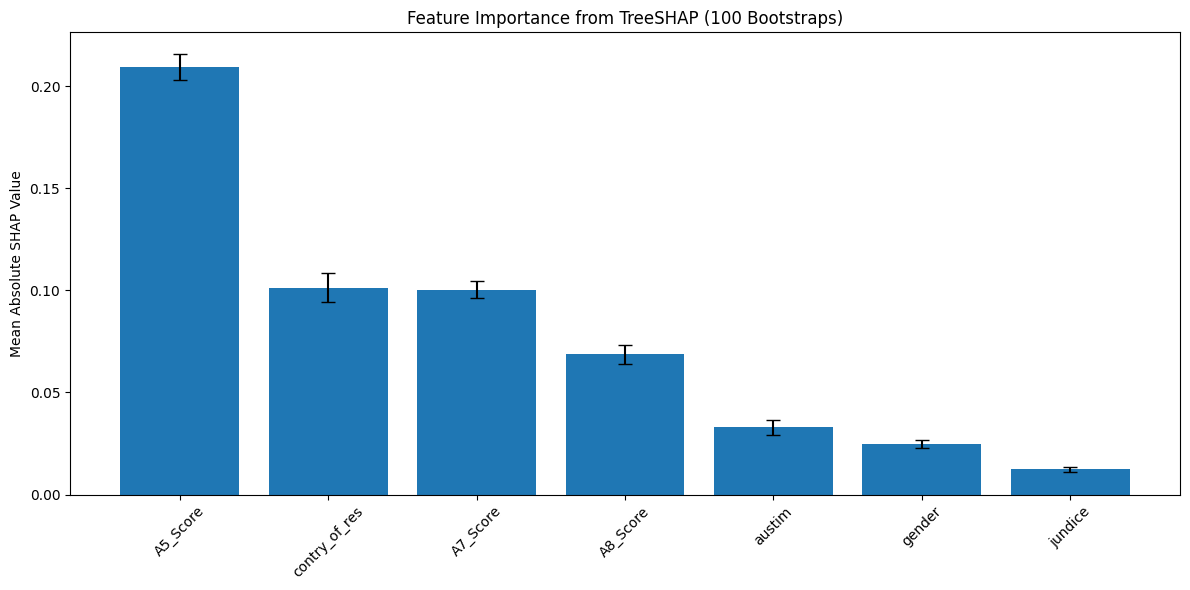


==== Top-5 Feature Comparison ====
Top-5 TreeSHAP Features: ['A5_Score', 'contry_of_res', 'A7_Score', 'A8_Score', 'austim']
Top-5 mRMR Features    : ['contry_of_res', 'A7_Score', 'A8_Score', 'gender', 'A5_Score']
Overlap                : {'A5_Score', 'A7_Score', 'A8_Score', 'contry_of_res'}
Jaccard Similarity     : 0.67


In [5]:
import pandas as pd
# Load the dataset
df=pd.read_csv("Autism-Adult.csv")
df.head()
# Missing values
df=df.dropna()
df.isnull().sum()
df=df.replace('?',0)
# Create feature set and target set
x=df.drop(['id','Class/ASD','used_app_before','age_desc','relation','result','ethnicity' ],axis=1)
y=df['Class/ASD']
# Categorical encoding
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
# Encoding Sex
le.fit(x['gender'])
x['gender']=le.transform(x['gender'])
# Encoding Country of residence
le.fit(x['contry_of_res'])
x['contry_of_res']=le.transform(x['contry_of_res'])
# Encoding Jaundice
le.fit(x['jundice'])
x['jundice']=le.transform(x['jundice'])
# Encoding autism
le.fit(x['austim'])
x['austim']=le.transform(x['austim'])
# Encoding age
le.fit(x['age'])
x['age']=le.transform(x['age'])
X=x
# Set the feature names for X
feature_names = X.columns.tolist()

# Use mRMR to select the top 14 features
k = 7
top_k_feature_names = mRMR(X, 'MID', k)
X_mrmr = X[top_k_feature_names]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_mrmr, y, test_size=0.2, random_state=2)

# Train a Random Forest classifier on the selected features
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# TreeSHAP analysis over multiple bootstrap trials
n_trials = 100
shap_importance_matrix = []

for seed in range(n_trials):
    # Bootstrap test set using only selected features
    X_boot = X_test.sample(frac=1.0, replace=True, random_state=seed)

    # Initialize SHAP explainer
    explainer = shap.TreeExplainer(clf)
    shap_vals = explainer.shap_values(X_boot)

    # Handle SHAP output formats
    if isinstance(shap_vals, list):
        shap_values_class1 = shap_vals[1]  # Class 1 (ASD = Yes)
    elif isinstance(shap_vals, np.ndarray) and shap_vals.ndim == 3:
        shap_values_class1 = shap_vals[:, :, 1]
    else:
        raise ValueError("Unexpected SHAP value format")

    # Compute mean absolute SHAP values
    mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)

    # Validate SHAP shape
    if len(mean_abs_shap) == len(top_k_feature_names):
        shap_importance_matrix.append(mean_abs_shap)
    else:
        raise ValueError(f"SHAP output size {len(mean_abs_shap)} != selected features {len(top_k_feature_names)}")

# Create SHAP importance DataFrame
shap_df = pd.DataFrame(shap_importance_matrix, columns=top_k_feature_names)

# Calculate mean and std SHAP importances
shap_mean = shap_df.mean()
shap_std = shap_df.std()

# Build SHAP summary DataFrame
shap_summary = pd.DataFrame({
    'Mean SHAP': shap_mean,
    'Std SHAP': shap_std
}).sort_values(by='Mean SHAP', ascending=False)

# Add feature rank
shap_summary['Rank'] = shap_summary['Mean SHAP'].rank(ascending=False)

# Print SHAP importance summary
print("==== SHAP Importance Summary (Top 7 Features) ====")
print(shap_summary)

# Plot SHAP importance with error bars
plt.figure(figsize=(12, 6))
plt.bar(shap_summary.index, shap_summary['Mean SHAP'], yerr=shap_summary['Std SHAP'], capsize=5)
plt.xticks(rotation=45)
plt.ylabel("Mean Absolute SHAP Value")
plt.title("Feature Importance from TreeSHAP (100 Bootstraps)")
plt.tight_layout()
plt.show()

# Compare top-5 SHAP and mRMR features
top5_shap = shap_summary.head(5).index.tolist()
top5_mrmr = top_k_feature_names[:5]
intersection = set(top5_shap) & set(top5_mrmr)

print("\n==== Top-5 Feature Comparison ====")
print(f"Top-5 TreeSHAP Features: {top5_shap}")
print(f"Top-5 mRMR Features    : {top5_mrmr}")
print(f"Overlap                : {intersection}")
print(f"Jaccard Similarity     : {len(intersection) / len(set(top5_shap + top5_mrmr)):.2f}")
